In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.linear_model import SGDRegressor
from random import sample
from functools import lru_cache
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from tqdm import tqdm
import random

from sklearn.datasets import make_classification
from sklearn.preprocessing import minmax_scale
from scipy.stats import truncnorm
from scipy.stats import skewnorm

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestNeighbors

from utils import ServiceParams, vectorize_for_bonus_predict, vectorize_for_neighbours_predict

import pickle

SEED = 42

random.seed(SEED)
np.random.seed(SEED)

In [3]:
train_dataset_len = 20_000
test_dataset_len = 5000

(array([9.000e+00, 3.010e+02, 9.250e+02, 0.000e+00, 1.021e+03, 9.770e+02,
        9.900e+02, 0.000e+00, 9.780e+02, 9.230e+02, 0.000e+00, 9.010e+02,
        9.290e+02, 8.570e+02, 0.000e+00, 8.630e+02, 7.890e+02, 0.000e+00,
        7.670e+02, 7.830e+02, 6.870e+02, 0.000e+00, 6.760e+02, 5.870e+02,
        0.000e+00, 5.530e+02, 5.510e+02, 4.820e+02, 0.000e+00, 4.640e+02,
        4.100e+02, 3.960e+02, 0.000e+00, 3.790e+02, 3.120e+02, 0.000e+00,
        3.310e+02, 2.450e+02, 2.290e+02, 0.000e+00, 2.220e+02, 1.840e+02,
        0.000e+00, 1.550e+02, 1.720e+02, 1.280e+02, 0.000e+00, 1.140e+02,
        9.600e+01, 0.000e+00, 1.110e+02, 5.400e+01, 6.400e+01, 0.000e+00,
        6.000e+01, 4.800e+01, 4.100e+01, 0.000e+00, 3.500e+01, 2.600e+01,
        0.000e+00, 3.300e+01, 1.900e+01, 2.500e+01, 0.000e+00, 1.500e+01,
        2.700e+01, 0.000e+00, 8.000e+00, 1.300e+01, 6.000e+00, 0.000e+00,
        3.000e+00, 8.000e+00, 0.000e+00, 6.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00, 0.000e+0

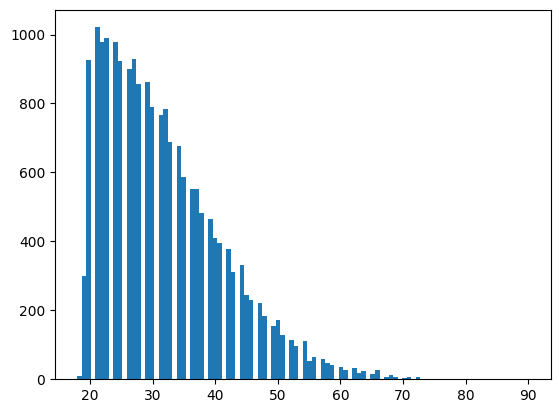

In [4]:
skewness = 30

age = skewnorm.rvs(a = skewness, size=train_dataset_len)
age = minmax_scale(age, feature_range=(18, 90))
age = age.round()
df_train = pd.DataFrame(age, columns=['age'])

age = skewnorm.rvs(a = skewness, size=test_dataset_len)
age = minmax_scale(age, feature_range=(18, 90))
age = age.round()
df_test = pd.DataFrame(age, columns=['age'])

plt.hist(df_train.age, bins=100)

In [5]:
# Service engage type
merchant_mcc_and_description = [
    "Electronics: Products such as smartphones, laptops, tablets, TVs, and gaming consoles",
    "Fashion: Clothing, shoes, handbags, accessories, and jewelry",
    "Beauty and personal care: Makeup, skincare, haircare, and grooming products",
    "Home and kitchen: Appliances, furniture, home decor, and cookware",
    "Sports and fitness: Athletic clothing, equipment, and supplements",
    "Toys and games: Board games, puzzles, action figures, and dolls",
    "Books and media: Fiction and non-fiction books, magazines, and DVDs",
    "Food and beverages: Snacks, drinks, and packaged foods",
    "Health and wellness: Vitamins, supplements, and medical devices",
    "Automotive: Cars, motorcycles, bicycles, and accessories",
    "Pet supplies: Products such as food, toys, and accessories for dogs, cats, and other pets",
    "Office supplies: Stationery, printers, and office furniture",
    "Music: Instruments, sheet music, and audio equipment",
    "Travel and leisure: Luggage, travel accessories, and camping gear",
    "Art and crafts: Supplies for drawing, painting, and crafting",
    "Garden and outdoor: Tools, planters, and outdoor furniture",
    "Baby and kids: Clothing, toys, and baby gear",
    "Industrial and scientific: Laboratory equipment, machinery, and scientific instruments",
    "Party supplies: Decorations, party favors, and supplies for hosting events",
    "Education and learning: Products such as textbooks, online courses, educational toys, and educational software for learners of all ages"
]

merchant_mcc = ['electronics',
 'fashion',
 'beauty and personal care',
 'home and kitchen',
 'sports and fitness',
 'toys and games',
 'books and media',
 'food and beverages',
 'health and wellness',
 'automotive',
 'pet supplies',
 'office supplies',
 'music',
 'travel and leisure',
 'art and crafts',
 'garden and outdoor',
 'baby and kids',
 'industrial and scientific',
 'party supplies',
 'education and learning']

bonus_type = [
    'welcome',
    'loyalty',
    'discount',
    'cashback',
    'up-sell',
    'gift',
    'early-access',
]

merchant_id_to_amount_range = {
    0: ['electronics', range(50, 10_000)],
    1: ['fashion', range(10, 10_000)],
    2: ['beauty and personal care', range(5, 500)],
    3: ['home and kitchen', range(10, 20_000)],
    4: ['sports and fitness', range(5, 5_000)],
    5: ['toys and games', range(5, 1000)],
    6: ['books and media', range(5, 1000)],
    7: ['food and beverages', range(1, 100)],
    8: ['health and wellness', range(5, 1000)],
    9: ['automotive', range(5_000, 100_000)],
    10: ['pet supplies', range(5, 1000)],
    11: ['office supplies', range(1, 10_000)],
    12: ['music', range(50, 10_000)],
    13: ['travel and leisure', range(50, 10_000)],
    14: ['art and crafts', range(5, 1000)],
    15: ['garden and outdoor', range(10, 20_000)],
    16: ['baby and kids', range(5, 1_000)],
    17: ['industrial and scientific', range(10, 100_000)],
    18: ['party supplies', range(5, 1_000)],
    19: ['education and learning', range(10, 10_000)]
 }

id2merchantName = { i : desc for i, desc in enumerate(merchant_mcc) }
merchantName2id = { desc : i for i, desc in enumerate(merchant_mcc) }
id2bonusName = { i : desc for i, desc in enumerate(bonus_type) }
bonusName2id = { desc : i for i, desc in enumerate(bonus_type) }
id2merchantName

{0: 'electronics',
 1: 'fashion',
 2: 'beauty and personal care',
 3: 'home and kitchen',
 4: 'sports and fitness',
 5: 'toys and games',
 6: 'books and media',
 7: 'food and beverages',
 8: 'health and wellness',
 9: 'automotive',
 10: 'pet supplies',
 11: 'office supplies',
 12: 'music',
 13: 'travel and leisure',
 14: 'art and crafts',
 15: 'garden and outdoor',
 16: 'baby and kids',
 17: 'industrial and scientific',
 18: 'party supplies',
 19: 'education and learning'}

In [6]:
def get_truncated_normal(mean=0, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

In [7]:
number_of_stores = 1000
merchants_df = pd.DataFrame(index=range(0,number_of_stores), columns=['merchant_mcc', 'bonuses_available'])
def generate_random_stores(row):
    row['merchant_mcc'] = sample(merchant_mcc, 1)[0]
    row['bonuses_available'] = sample(bonus_type, random.randint(0, len(bonus_type)))
    return row
    
merchants_df = merchants_df.apply(generate_random_stores, axis=1)
merchants_df

,merchant_mcc,bonuses_available
0,home and kitchen,[]
1,health and wellness,"[loyalty, early-access, welcome]"
2,industrial and scientific,[up-sell]
3,travel and leisure,[]
4,electronics,[loyalty]
...,...,...
995,industrial and scientific,[discount]
996,garden and outdoor,"[loyalty, discount, welcome, early-access]"
997,home and kitchen,"[gift, cashback, discount]"
998,electronics,"[early-access, discount]"


In [8]:
# Purchase history generation {purchase_type, amount} random purchase_type, random amount
min_number_purchase = 0
max_number_purchase = 50
min_amount_bonus_points_available = 0
max_amount_bonus_points_available = 99_999_999
min_amount_assets_available = 0
max_amount_assets_available = 99_999_999
min_number_transactions = 0
max_number_transactions = 99_999_999

random_rating = get_truncated_normal(mean=10, sd=2, low=1, upp=5).rvs(train_dataset_len)

def generate_purchase_history(row, train=True):
    number_of_purchases = np.random.randint(min_number_purchase, max_number_purchase, 1)[0]
    purchase_preferences = np.random.randint(0, len(merchant_id_to_amount_range), 1)[0] 
    truncated_normal = get_truncated_normal(mean=purchase_preferences, sd=2, low=0, upp=len(merchant_id_to_amount_range)-1)
    indices = truncated_normal.rvs(number_of_purchases).round()
    current_merchant_id = random.randint(0, number_of_stores-1)
    current_merchant = merchants_df.iloc[current_merchant_id]
    bonuses_available = current_merchant.bonuses_available
    purchase_history = []
    purchase_history_names = []
    rating = random_rating[row.name]
    for purchase_id in indices:
        purchase_name, range = merchant_id_to_amount_range[purchase_id]
        purchase_history.append([purchase_name, np.around(np.random.uniform(range[0], range[-1]+1, 1), 1)[0]])
        purchase_history_names.append(purchase_name)
    row['purchase_history'] = purchase_history
    row['rating'] = rating
    if train:
        row['current_merchant_id'] = current_merchant_id
        if len(bonuses_available) > 0 and rating >= np.random.uniform(1.0, 5.0):
            bonuse_to_offer = sample(bonuses_available, 1)[0]
        else:
            bonuse_to_offer = ''
        row['bonus_to_offer'] = bonuse_to_offer
    return row


df_train = df_train.apply(generate_purchase_history, axis = 1)
df_test = df_test.apply(generate_purchase_history, train=False, axis = 1)
df_train

In [ ]:
service_params = ServiceParams(
    max_number_purchase = max_number_purchase,
    bonus_type = bonus_type,
    merchantName2id = merchantName2id,
    bonusName2id = bonusName2id,
)

In [ ]:
vectors =  np.array(df_train.apply(vectorize_for_bonus_predict, merchant_id=None, merchants_db=merchants_df, params=service_params, axis=1).to_list())
X = vectors[:,:-1].astype(np.float32)
y = vectors[:,-1].astype(np.int32)
X, y, X.shape, y.shape

In [ ]:
# gbc_clf = GradientBoostingClassifier(verbose=1, random_state=SEED)
gbc_clf = RandomForestClassifier(verbose=1, random_state=SEED)
gbc_clf.fit(X, y)

In [ ]:
gbc_clf.predict_proba(X[5:10]).argmax(axis=1)

In [ ]:
vectors =  np.array(df_train.apply(vectorize_for_neighbours_predict, params=service_params, axis=1).to_list())
X = vectors.astype(np.float32)
X

In [ ]:
nbrs_clf = NearestNeighbors(n_neighbors=5, algorithm='ball_tree')
nbrs_clf.fit(X)

In [ ]:
distances, indices = nbrs_clf.kneighbors(X[:1])
nearest = df_train.iloc[indices[0]]
nearest, distances

In [ ]:
# Import models and data for inference

gbc_filename = 'data/gbc.clf'
nbrs_filename = 'data/nbrs.clf'
service_params_filename = 'data/service.params'
pickle.dump(gbc_clf, open(gbc_filename, 'wb'))
pickle.dump(nbrs_clf, open(nbrs_filename, 'wb'))
pickle.dump(service_params, open(service_params_filename, 'wb'))
df_train.to_csv('data/train_db.csv', index=False)
df_test.to_csv('data/test_db.csv', index=False)
merchants_df.to_csv('data/merchants_db.csv', index=False)